In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVCal
from glob import glob
from astropy import units as u
from astropy import constants as c
from astropy.time import Time
from astropy.coordinates import get_body, SkyCoord, AltAz, EarthLocation, Angle
from copy import deepcopy
from pyuvdata import utils

To turn this into a script:

1) we need to get all of the files for all of the days in `oldpath` (writing a smart `glob` statement that gets all the `xx` files, say, then figures out how to get all polarizations into a single file) and we're going to have to make sure that the `newpath` day files exist (James needs to do this)

2) Do a check if all the data are flagged and if the sun is up (sun alt < -5).  If either is true, just don't convert that file

3) We need to build a flag waterfall (Ntimes x Nfreqs) that's the same for all visibilities (baselines) to make imaging and comparison between polarizations and between frequencies much simpler.  We want to exclude bad antennas when building this flag array.

a) Count up the number of times a given frequency / time (t/f) bin was flagged over all baselines.  If the count > threshold, then that t/f bin gets flagged for everybody.  (Least conservative)
    
b) Logical or of baselines (if anybody thinks that t/f bin is bad, it's bad)
    
c) If at any time, fraction of frequencies that's bad > threshold, through all the frequen cies at that time.  If at any frequency, all the fraction of times > threshold, through all times at that frequency.
    
4) We want to flag all bad antennas (Cases a, b, c above) and also the edges of the band.

5) Write out UVFlag files for Cases a, b, c for later use.  Tricky thing: UVFlag object is similar to pyuvdata in that it has a dimension that's Nbls * Ntimes.  So we have to loop over baselines, putting the same flags back into the each visiblity.

6) Write out the new uvh5 file with original flags (?) but all polarizations

In [3]:
oldpath = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/'
newpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/'

In [4]:
uvdraw = UVData()

In [5]:
uvdraw.read(glob(oldpath+'RawData/2457549/zen.2457549.64017.*.HH.uvcRP'))

Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [6]:
# Check for whether all the data are flagged and whether the sun is up

In [7]:
numflags = uvdraw.flag_array.sum()
numdata = np.array(uvdraw.flag_array.shape).prod()
if (numflags == numdata):
    print('All are flagged')
else:
    print('{:.2f}% are flagged'.format(numflags/numdata*100.))

7.34% are flagged


In [8]:
times = Time(np.unique(uvdraw.time_array), format='jd')

In [9]:
# HERA Lat / Lon
lat, lon, alt = uvdraw.telescope_location_lat_lon_alt_degrees
latitude = Angle(lat*u.deg)
longitude = Angle(lon*u.deg)
# This is GEODETIC
karoo = EarthLocation(longitude, latitude, height=alt*u.m)

In [10]:
sun = get_body('sun', times)

In [11]:
sun_altaz = sun.transform_to(AltAz(location = karoo))#, obstime=times))

In [14]:
#Is the sun above the horizon?
if np.sum(sun_altaz.alt.deg > -5) == 0:
    

0

In [12]:
# Can we also check if all the baselines have the same flags?  
# I think this will simplify things a lot
# Also, identify bad antennas?  I think two of them just had their x/y reversed (?)
# How do I easily get all waterfalls?

In [14]:
# Check whether all waterfalls have the same flags

In [15]:
bls = uvdraw.get_antpairpols()

In [17]:
bad_ants = [22, 43, 80, 81]

In [27]:
nwaterfall = uvdraw.Ntimes * uvdraw.Nfreqs
waterfall_flags = np.zeros([uvdraw.Ntimes, uvdraw.Nfreqs], dtype='bool')
waterfall_hits = np.zeros([uvdraw.Ntimes, uvdraw.Nfreqs])
waterfall_flags_no_bad_ants = np.zeros([uvdraw.Ntimes, uvdraw.Nfreqs], dtype='bool')
waterfall_hits_no_bad_ants = np.zeros([uvdraw.Ntimes, uvdraw.Nfreqs])
flag_dict = {}

In [42]:
for bl in bls:
    fl = uvdraw.get_flags(bl)
    flag_dict[bl] = fl
    if (bl[0] in bad_ants) or (bl[1] in bad_ants):
        #continue
        print('Excluding', bl)
    else:
        
        waterfall_flags_no_bad_ants = np.logical_or(fl, waterfall_flags_no_bad_ants)
        waterfall_hits_no_bad_ants += fl
        
    waterfall_flags = np.logical_or(fl, waterfall_flags)
    waterfall_hits += fl
    #print(bl, '{:.2f}% flagged'.format(fl.sum()/nwaterfall*100.))

Excluding (9, 22, 'xx')
Excluding (9, 22, 'yy')
Excluding (9, 22, 'xy')
Excluding (9, 22, 'yx')
Excluding (9, 43, 'xx')
Excluding (9, 43, 'yy')
Excluding (9, 43, 'xy')
Excluding (9, 43, 'yx')
Excluding (9, 80, 'xx')
Excluding (9, 80, 'yy')
Excluding (9, 80, 'xy')
Excluding (9, 80, 'yx')
Excluding (9, 81, 'xx')
Excluding (9, 81, 'yy')
Excluding (9, 81, 'xy')
Excluding (9, 81, 'yx')
Excluding (10, 22, 'xx')
Excluding (10, 22, 'yy')
Excluding (10, 22, 'xy')
Excluding (10, 22, 'yx')
Excluding (10, 43, 'xx')
Excluding (10, 43, 'yy')
Excluding (10, 43, 'xy')
Excluding (10, 43, 'yx')
Excluding (10, 80, 'xx')
Excluding (10, 80, 'yy')
Excluding (10, 80, 'xy')
Excluding (10, 80, 'yx')
Excluding (10, 81, 'xx')
Excluding (10, 81, 'yy')
Excluding (10, 81, 'xy')
Excluding (10, 81, 'yx')
Excluding (20, 22, 'xx')
Excluding (20, 22, 'yy')
Excluding (20, 22, 'xy')
Excluding (20, 22, 'yx')
Excluding (20, 43, 'xx')
Excluding (20, 43, 'yy')
Excluding (20, 43, 'xy')
Excluding (20, 43, 'yx')
Excluding (20, 8

In [43]:
# OK, I'm glad I checked.  Flags are not homogenized across waterfalls, nor are 
# bad antennas flagged

# For this case, it seems that leaving out the flagged antennas doesn't change the 
# final logical OR of the flags, but this need not always be the case ...

In [44]:
print('{:.2f}% flagged'.format(waterfall_flags.sum()/nwaterfall*100.))

24.74% flagged


divide by zero encountered in log10


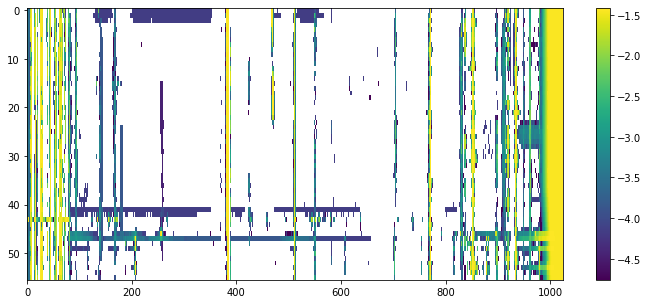

In [45]:
plt.figure(figsize=(12,5))
plt.imshow(np.log10(waterfall_hits/nwaterfall), aspect='auto')
plt.colorbar()
plt.show()

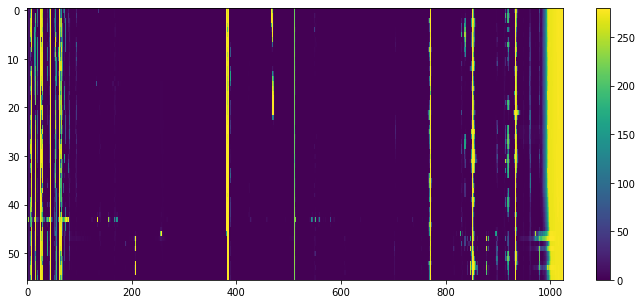

In [46]:
plt.figure(figsize=(12,5))
plt.imshow(waterfall_hits-waterfall_hits_no_bad_ants, aspect='auto')
plt.colorbar()
plt.show()
#How is this useful? Looking at the bad antennas

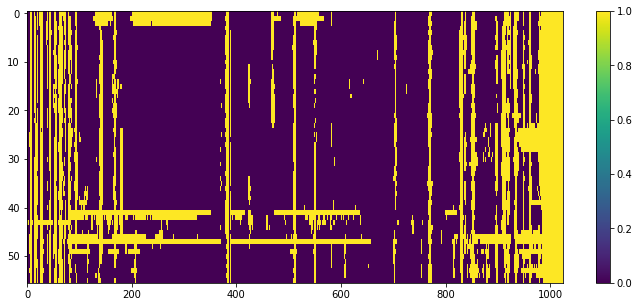

In [48]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(waterfall_flags_no_bad_ants,dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()
#start of master flag array
#next step is to look at each time and frequency and see if more than 
#a certain precentage is flagged, just flag the whole thing.

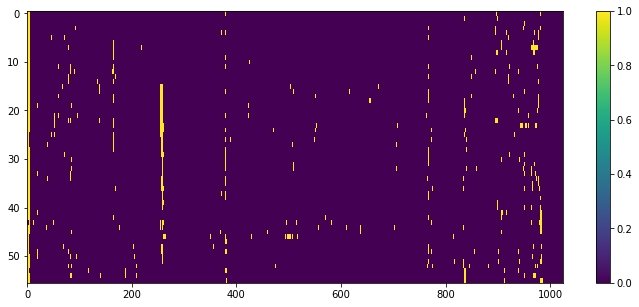

In [49]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(waterfall_flags,dtype='float64') - 
           np.array(waterfall_flags_no_bad_ants,dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

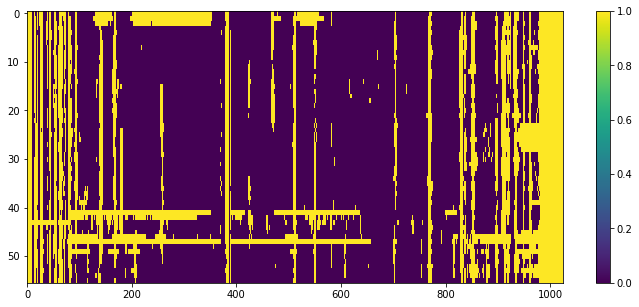

In [50]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(waterfall_flags,dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

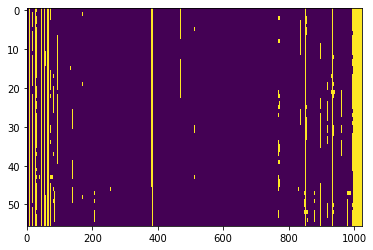

In [51]:
plt.imshow(flag_dict[(96, 105, 'xy')], aspect='auto')

In [52]:
# Let's add flagging for band edges and greedy thresholds in frequency and time
band_edges = np.logical_or(uvdraw.freq_array.squeeze() < 110e6, uvdraw.freq_array.squeeze() > 190e6)

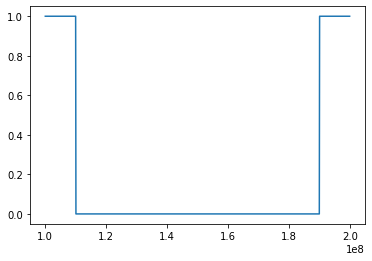

In [53]:
plt.plot(uvdraw.freq_array.squeeze(), band_edges)

In [54]:
waterfall_conservative = deepcopy(waterfall_flags)

In [55]:
waterfall_conservative[:,band_edges] = True

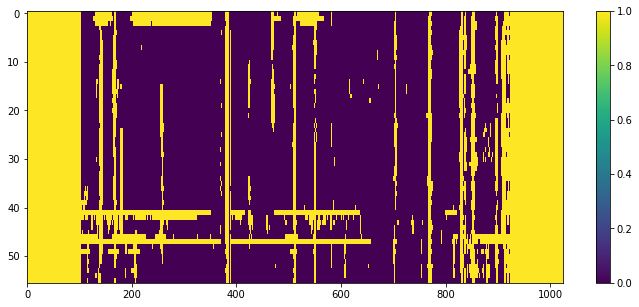

In [60]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(waterfall_conservative,dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

In [61]:
# Now let's be ultraconservative
waterfall_ultraconservative = deepcopy(waterfall_conservative)
time_frac = waterfall_conservative.sum(axis=1)/uvdraw.Nfreqs
freq_frac = waterfall_conservative.sum(axis=0)/uvdraw.Ntimes

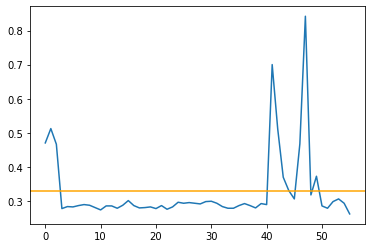

In [62]:
plt.plot(time_frac)
plt.axhline(0.33,color='orange')

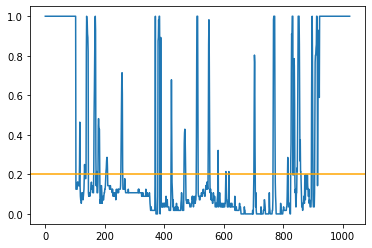

In [63]:
plt.plot(freq_frac)
plt.axhline(0.20,color='orange')

In [64]:
waterfall_ultraconservative[time_frac>0.33,:] = True
waterfall_ultraconservative[:,freq_frac>0.20] = True

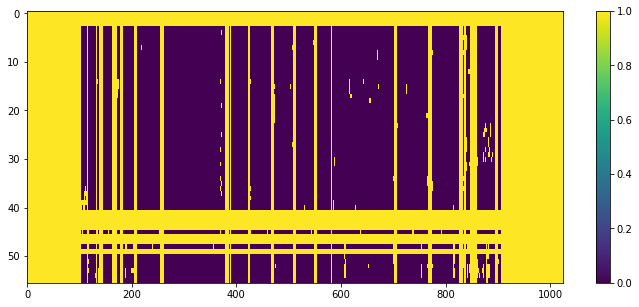

In [65]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(waterfall_ultraconservative,dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

In [66]:
def uvd_alter_bl(_uvd, bl, new_data, attr='data'):
    """ Modify the data in a UVData object by specified baseline, i.e., 
    all freq / time data for a particular waterfall """
    
    uvd = deepcopy(_uvd)
    
    inds = uvd._key2inds(bl)[0]
    
    """ Check that the new data is Ntimes x Nfreq """
    assert new_data.shape == (uvd.Ntimes, uvd.Nfreqs)
    
    """ Ugh ... how do I convert 'yy' to an index in the data array? """
    
    if attr == 'data':
        uvd.data_array[inds, 0, :, pol] = new_data
        
    if attr == 'flag':
        uvd.flag_array[inds, 0, :, pol] = new_data
        
    return uvd

In [157]:
utils.polstr2num?

In [160]:
uvdraw.polarization_array

array([-5, -6, -7, -8])

In [162]:
uvdraw.get_pols()

['xx', 'yy', 'xy', 'yx']

In [15]:
uvdraw.write_uvh5(newpath+'RawData/2457549/zen.2457549.64017.uvcRP.uvh5')